In [1]:
from latools import *

In [4]:
%matplotlib inline

In [5]:
d = analyse('latools/resources/test_data/')

4 Analysis Files Loaded:
1 standards, 3 samples
Analytes: Mg24 Mg25 Al27 Ca43 Ca44 Mn55 Sr88 Ba137 Ba138


In [6]:
d.despike()

Exponential Decay Coefficient not provided.
Coefficient will be determined from the washout
times of the standards (takes a while...).
-------------------------------------
Exponential Decay Coefficient: -2.77
-------------------------------------


In [10]:
d.trace_plots(outdir = 'testplots', ranges=True)

In [9]:
d.autorange()

In [7]:
d.bkgcorrect()

In [8]:
d.ratio()

In [11]:
d.load_params('test.param')
d.load_calibration()
# d.load_srm_ids('latools/resources/test_data/params/srm.rng')

In [12]:
d.calibrate()

In [15]:
d.trace_plots(dirpath='testplot')

TypeError: tplot() got an unexpected keyword argument 'plot_filt'

In [13]:
self = d.data_dict['A1-1']

### Threshold Testing

In [11]:
self.filt.clear_filters()

In [12]:
self.filter_threshold('Al27', 200E-6, 'below')

In [13]:
x,y,lim = self.filter_distribution('Al27',0.2, output=True, filt=True)

In [14]:
self.filt.off()
self.filt.on(filt=['Al27_thresh'])

In [15]:
self.filter_clustering('Al27', filt=True)

In [16]:
self.filt.off(filt='meanshift')

In [17]:
self.filter_clustering('Al27', filt=True, method='kmeans', n_clusters=2)

In [19]:
self.filt.off(filt='kmeans')

In [20]:
self.filter_clustering('Al27', filt=True, method='DBSCAN', n_clusters=2)

In [22]:
self.filt.off(filt='DBSCAN')

## Correlation Filter

In [115]:
from scipy.stats import pearsonr

In [288]:
def filter_correlation(self, x_analyte, y_analyte, window=None, r_threshold=0.9, p_threshold=0.05, filt=True):    
    # automatically determine appripriate window
    
    # make window odd
    if window % 2 != 1:
        window += 1
    
    params = locals()
    del(params['self'])
    
    if filt:
        ind = self.filt.make_filt([x_analyte, y_analyte])
    else:
        ind = ~np.zeros(self.Time.size, dtype=bool)
    
    x = self.focus[x_analyte]
    x[~ind] = np.nan
    xr = self.rolling_window(x, window, pad=np.nan)

    y = self.focus[y_analyte]
    y[~ind] = np.nan
    yr = self.rolling_window(y, window, pad=np.nan)

    r, p = zip(*map(pearsonr, xr,yr))
    
    r = np.array(r)
    p = np.array(p)
    
    cfilt = (abs(r) > r_threshold) & (p < p_threshold)
    cfilt = ~cfilt

    name = x_analyte + '_' + y_analyte + '_corr'
    
    self.filt.add_filt(name=name,
                       filt=cfilt,
                       info=x_analyte + ' vs. ' + y_analyte + ' correlation filter.',
                       params=params)
    self.filt.off(filt=name)
    self.filt.on(analyte=y_analyte, filt=name)
    
    return r, p
    
    

In [289]:
r, p = filter_correlation(self, 'Al27', 'Ba138', 30)

## Clustering Algorithms

### Plan
1. Make separate functions for the different methods.
2. Make a 'wrapper' function to call them all.

##### Want clustering that is:
1. Naive: determines number of clusters on its own.
2. Guided: you tell it number of clusters.

##### Methods:
1. Meanshift
2. DBSCAN
3. Affinity Propagation
4. Kmeans

In [230]:
import sklearn.cluster as cl
from sklearn import metrics
from sklearn import preprocessing
import warnings

In [179]:
def filter_clustering(self, analytes, filt=False, normalise=True, method='meanshift', **kwargs):
    params = locals()
    del(params['self'])
    
    # convert string to list, if single analyte
    if type(analytes) is str:
        analytes = [analytes]
        
    # generate filter
    if filt:
        ind = self.filt.make_filt(analytes)
    else:
        ind = ~np.isnan(self.focus[analyte[0]])
    
    # get indices for data passed to clustering
    sampled = np.arange(self.Time.size)[ind]
    
    # generate data for clustering
    if len(analytes) == 1:
        # if single analyte
        d = self.focus[analytes[0]][ind]     
        ds = np.array(list(zip(d,np.zeros(len(d)))))
    else:
        # package multiple analytes
        d = [self.focus[a][ind] for a in analytes]
        ds = np.vstack(d).T
        
    if normalise | (len(analytes) > 1):
        ds = preprocessing.scale(ds)
    
    method_key = {'kmeans': self.cluster_kmeans,
                  'DBSCAN': self.cluster_DBSCAN,
                  'meanshift': self.cluster_meanshift}
    
    cfun = method_key[method]
    
    filts = cfun(self, ds, **kwargs)  # return dict of cluster_no: (filt, params)
    
    resized = {}
    for k, v in filts.items():
        resized[k] = np.zeros(self.Time.size, dtype=bool)
        resized[k][sampled] = v
    
    namebase = 'cluster_' + method + '_' + '-'.join(analytes)
    info = '-'.join(analytes) + ' cluster filter.'
    
    if method == 'DBSCAN':
        for k,v in resized.items():
            if type(k) is str:
                name = namebase + '_core'
            elif k < 0:
                name = namebase + '_noise'
            else:
                name = namebase + '_{:.0f}'.format(k)
            self.filt.add_filt(name, v, info=info, params=params)
    else:
        for k,v in resized.items():
            name = namebase + '_{:.0f}'.format(k)
            self.filt.add_filt(name, v, info=info, params=params)

In [120]:
self.filter_clustering = filter_clustering


In [121]:
self.filter_clustering(self, ['Al27'], filt=True, method='kmeans', n_clusters=3)

In [122]:
print(self.filt)

Filter Name            Mg24   Mg25   Al27   Ca43   Ca44   Mn55   Sr88   Ba137  Ba138  
Al27_Ba138_corr        False  False  False  False  False  False  False  False  True   
Al27_distribution_0    False  False  False  False  False  False  False  False  False  
Al27_distribution_1    False  False  False  False  False  False  False  False  False  
Al27_distribution_2    False  False  False  False  False  False  False  False  False  
Al27_distribution_3    False  False  False  False  False  False  False  False  False  
Al27_thresh            True   True   True   True   True   True   True   True   True   
cluster_kmeans_Al27_0  True   True   True   True   True   True   True   True   True   
cluster_kmeans_Al27_1  True   True   True   True   True   True   True   True   True   



In [123]:
# implement single filter visualisation in tplot

In [124]:
def cluster_meanshift(self, data, bandwidth=None, bin_seeding=True):
    if bandwidth is None:
        bandwidth = cl.estimate_bandwidth(data)
    
    ms = cl.MeanShift(bandwidth=bandwidth)
    ms.fit(data)
    
    labels = ms.labels_
    labels_unique = np.unique(labels)
    
    out = {}
    for lab in labels_unique:
        out[lab] = labels == lab
    
    return out

In [125]:
def cluster_kmeans(self, data, n_clusters):
    km = cl.KMeans(2)
    kmf = km.fit(data)
    
    labels = kmf.labels_
    labels_unique = np.unique(labels)
    
    out = {}
    for lab in labels_unique:
        out[lab] = labels == lab
    
    return out

In [268]:
def cluster_DBSCAN(self, data, eps=None, min_samples=None, n_clusters=None, maxiter=200):
    if min_samples is None:
        min_samples = self.Time.size // 20
        
    if n_clusters is None:
        if eps is None:
            eps = 0.3
        db = cl.DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    else:
        clusters = 0
        eps_temp = 1 / .95
        niter = 0
        while clusters < n_clusters:
            clusters_last = clusters
            eps_temp *= 0.95
            db = cl.DBSCAN(eps=eps_temp, min_samples=15).fit(nds)
            clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
            if clusters < clusters_last:
                eps_temp *= 1/0.95
                db = cl.DBSCAN(eps=eps_temp, min_samples=15).fit(nds)
                clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
                warnings.warn('\n\n***Unable to find {:.0f} clusters in data. Found {:.0f} with an eps of {:.2e}'.format(n_clusters, clusters, eps_temp))
                break
            niter += 1
            if niter == maxiter:
                warnings.warn('\n\n***Maximum iterations ({:.0f}) reached, {:.0f} clusters not found.\nDeacrease min_samples or n_clusters (or increase maxiter).'.format(maxiter, n_clusters))
                break
    
    labels = db.labels_
    labels_unique = np.unique(labels)
    
    core_samples_mask = np.zeros_like(labels)
    core_samples_mask[db.core_sample_indices_] = True

    out = {}
    for lab in labels_unique:
        out[lab] = labels == lab
    
    out['core'] = core_samples_mask
        
    return out

### Test

In [269]:
self.filter_clustering = filter_clustering

self.cluster_DBSCAN = cluster_DBSCAN
self.cluster_kmeans = cluster_kmeans
self.cluster_meanshift = cluster_meanshift

In [270]:
self.filt.off(filt='cluster')

In [271]:
self.filter_clustering(self, 'Al27', filt=True, method='DBSCAN', n_clusters=4)

/Users/oscarbranson/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:22: UserWarning: 

***Unable to find 4 clusters in data. Found 3 with an eps of 2.64e-01


In [272]:
print(self.filt)

Filter Name                     Mg24   Mg25   Al27   Ca43   Ca44   Mn55   Sr88   Ba137  Ba138  
Al27_Ba138_corr                 False  False  False  False  False  False  False  False  True   
Al27_distribution_0             False  False  False  False  False  False  False  False  False  
Al27_distribution_1             False  False  False  False  False  False  False  False  False  
Al27_distribution_2             False  False  False  False  False  False  False  False  False  
Al27_distribution_3             False  False  False  False  False  False  False  False  False  
Al27_thresh                     True   True   True   True   True   True   True   True   True   
cluster_DBSCAN_Al27_0           True   True   True   True   True   True   True   True   True   
cluster_DBSCAN_Al27_1           True   True   True   True   True   True   True   True   True   
cluster_DBSCAN_Al27_2           True   True   True   True   True   True   True   True   True   
cluster_DBSCAN_Al27_core        True   T

In [154]:
filts = self.filt.get_components('DBSCAN')

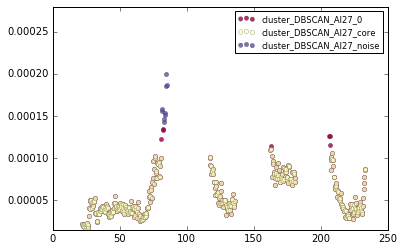

In [155]:
cs = plt.cm.get_cmap('Spectral')
cs = itertools.cycle(cs(np.linspace(0,1,len(filts))))

fig, ax = plt.subplots(1,1)

for k in sorted(filts.keys()):
    ind = filts[k]
    ax.scatter(self.Time[ind], self.Al27[ind], lw=0.2, c=next(cs), alpha=0.8, label=k)
    
ax.set_ylim(np.nanmin(self.Al27), np.nanmax(self.Al27))
ax.legend()

### Dev

In [284]:
ind = self.filt.make_filt('Al27')
d = self.Al27
ds = d[ind]
sampled = np.arange(self.Time.size)[ind]

filt = ds < 6.3E-5

outblank = ~np.isnan(d)

out = outblank.copy()
out[sampled] = filt

#### Preprocessing

In [161]:
ind = self.filt.make_filt('Al27')

d = self.Al27[ind]
d = d[~np.isnan(d)]
# bandwidth = np.std(d) / 100
ds = np.array(list(zip(d,np.zeros(len(d)))))
nds = preprocessing.scale(ds)

ds2 = np.vstack([self.Al27[self.filt.make_filt(['Al27','Ba138'])], self.Ba138[self.filt.make_filt(['Al27','Ba138'])]]).T
nds2 = preprocessing.scale(ds2)

t = self.Time[ind]

#### MeanShift

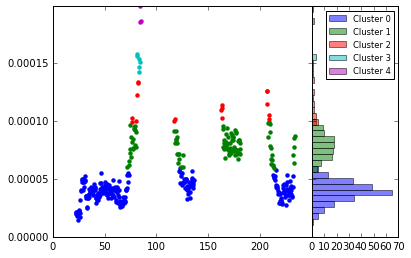

In [162]:
bandwidth = cl.estimate_bandwidth(nds)
ms = cl.MeanShift(bandwidth=bandwidth, bin_seeding=True)

ms.fit(nds)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

cs = itertools.cycle(['b','g','r','c','m','y','k'])

fig = plt.figure()
sax = fig.add_axes([.1,.1,.6,.8])
hax = fig.add_axes([.7,.1,.2,.8])

bins = np.linspace(0,max(d),40)
for k in range(n_clusters_):
    my_members = labels == k
    c = next(cs)
    sax.scatter(t[my_members], ds[my_members, 0], label='Cluster {:.0f}'.format(k), lw=0, color=c)
    hax.hist(ds[my_members, 0], bins, label='Cluster {:.0f}'.format(k), color=c, orientation='horizontal', alpha=0.5)
    
#     print("cluster {0}: {1}".format(k, D[my_members, 0]))
# sax.legend()

sax.set_ylim(0, max(d))
hax.set_ylim(0, max(d))

hax.set_yticklabels([])
sax.set_xticks(sax.get_xticks()[:-1])

hax.legend()

- bandwidth

#### K-Means

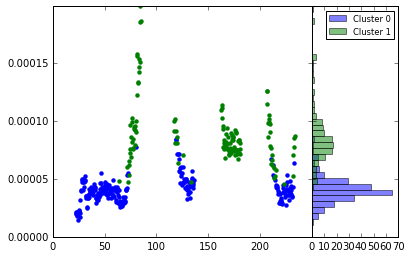

In [163]:
km = cl.KMeans(2)
kmf = km.fit(nds2)


# plot

cs = itertools.cycle(['b','g','r','c','m','y','k'])

fig = plt.figure()
sax = fig.add_axes([.1,.1,.6,.8])
hax = fig.add_axes([.7,.1,.2,.8])

for i in np.unique(kmf.labels_):
    ind = kmf.labels_ == i
    c = next(cs)
    sax.scatter(t[ind], d[ind], c=c, lw=0)
    hax.hist(d[ind], bins, label='Cluster {:.0f}'.format(i), color=c, orientation='horizontal', alpha=0.5)

sax.set_ylim(0, max(d))
hax.set_ylim(0, max(d))

hax.set_yticklabels([])
sax.set_xticks(sax.get_xticks()[:-1])

hax.legend()

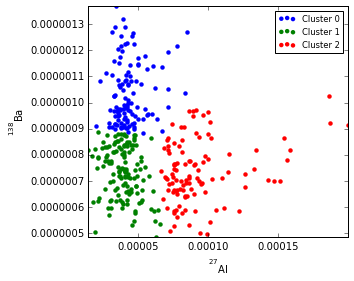

In [164]:
km = cl.KMeans(3)
kmf = km.fit(nds2)


# plot

cs = itertools.cycle(['b','g','r','c','m','y','k'])

fig = plt.figure()
sax = fig.add_axes([.1,.1,.6,.8])
# hax = fig.add_axes([.7,.1,.2,.8])

for i in np.unique(kmf.labels_):
    ind = kmf.labels_ == i
    c = next(cs)
    sax.scatter(ds2[ind,0], ds2[ind,1], c=c, lw=0, label='Cluster {:.0f}'.format(i))
#     hax.hist(d[ind], bins, label='Cluster {:.0f}'.format(i), color=c, orientation='horizontal', alpha=0.5)

sax.set_ylim(min(ds2[:,1]), max(ds2[:,1]))
sax.set_xlim(min(ds2[:,0]), max(ds2[:,0]))

# hax.set_ylim(0, max(d))

# hax.set_yticklabels([])
# sax.set_xticks(sax.get_xticks()[:-1])

sax.set_xlabel(self.pretty_element('Al27'))
sax.set_ylabel(self.pretty_element('Ba138'))

sax.legend()

- n_clusters

#### DBSCAN

In [165]:
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)


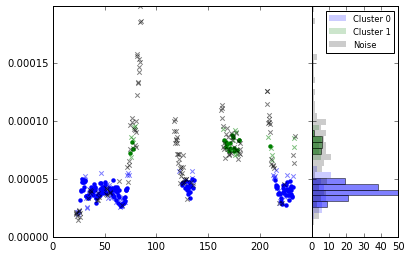

In [315]:
# scaler = StandardScaler()
# scaler.fit(ds)
nds = preprocessing.scale(nds2)


db = cl.DBSCAN(eps=0.3, min_samples=15).fit(nds)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)


fig = plt.figure()
sax = fig.add_axes([.1,.1,.6,.8])
hax = fig.add_axes([.7,.1,.2,.8])

cs = itertools.cycle(['b','g','r','c','m','y','k'])

for k in unique_labels:
    if k == -1:
        # Black used for noise.
        col = 'k'
        lab = 'Noise'
    else:
        col = next(cs)
        lab = 'Cluster {:.0f}'.format(k)

    class_member_mask = (labels == k)

    ind = [class_member_mask & core_samples_mask]
    sax.scatter(t[ind], d[ind], color=col, lw=0)
    hax.hist(d[ind], bins, color=col, orientation='horizontal', alpha=0.5)
    
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
    
    ind = [class_member_mask & ~core_samples_mask]
    sax.scatter(t[ind], d[ind], color=col, lw=1, marker='x', alpha=0.5)
    hax.hist(d[ind], bins, color=col, orientation='horizontal', label=lab, alpha=0.2, lw=0)
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=6)

sax.set_ylim(0, max(d))
hax.set_ylim(0, max(d))

hax.set_yticklabels([])
sax.set_xticks(sax.get_xticks()[:-1])

hax.legend()

- eps
- min_samples

In [ ]:
def cluster_DBSCAN(self, data, eps=None, min_samples=None, n_clusters=None):
    if min_samples is None:
        min_samples = self.Time.size // 20
        
    if n_clusters is None:
        if eps is None:
            eps = 0.3
        db = cl.DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    else:
        clusters = n_clusters + 1
        eps_temp = 0.8
        while clusters > n_clusters:
            db = cl.DBSCAN(eps=eps_temp, min_samples=min_samples).fit(data)
            clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
            eps_temp *= 0.9
    
    labels = db.labels_
    labels_unique = np.unique(labels)
    
    core_samples_mask = np.zeros_like(labels)
    core_samples_mask[db.core_sample_indices_] = True

    out = {}
    for lab in labels_unique:
        out[lab] = labels == lab
    
    out['core'] = core_samples_mask
        
    return out

In [174]:
n_clusters = 3

clusters = n_clusters + 1

In [175]:
clusters > n_clusters

True

In [176]:
# scaler = StandardScaler()
# scaler.fit(ds)

n_clusters = 3

clusters = n_clusters - 1
eps_temp = 1 / .9
while clusters < n_clusters:
    eps_temp *= 0.9
    print(eps_temp)
    db = cl.DBSCAN(eps=eps_temp, min_samples=15).fit(nds)
    clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    


    
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# unique_labels = set(labels)

# else:
#     clusters = n_clusters + 1
#     eps_temp = 0.8
#     while clusters > n_clusters:
#         db = cl.DBSCAN(eps=eps_temp, min_samples=min_samples).fit(data)
#         clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
#         eps_temp *= 0.9


# fig = plt.figure()
# sax = fig.add_axes([.1,.1,.6,.8])
# hax = fig.add_axes([.7,.1,.2,.8])

# cs = itertools.cycle(['b','g','r','c','m','y','k'])

# for k in unique_labels:
#     if k == -1:
#         # Black used for noise.
#         col = 'k'
#         lab = 'Noise'
#     else:
#         col = next(cs)
#         lab = 'Cluster {:.0f}'.format(k)

#     class_member_mask = (labels == k)

#     ind = [class_member_mask & core_samples_mask]
#     sax.scatter(t[ind], d[ind], color=col, lw=0)
#     hax.hist(d[ind], bins, color=col, orientation='horizontal', alpha=0.5)
    
# #     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
# #              markeredgecolor='k', markersize=14)
    
#     ind = [class_member_mask & ~core_samples_mask]
#     sax.scatter(t[ind], d[ind], color=col, lw=1, marker='x', alpha=0.5)
#     hax.hist(d[ind], bins, color=col, orientation='horizontal', label=lab, alpha=0.2, lw=0)
# #     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
# #              markeredgecolor='k', markersize=6)

# sax.set_ylim(0, max(d))
# hax.set_ylim(0, max(d))

# hax.set_yticklabels([])
# sax.set_xticks(sax.get_xticks()[:-1])

# hax.legend()

1.0
0.9
0.81
0.7290000000000001
0.6561000000000001
0.5904900000000002
0.5314410000000002
0.47829690000000014
0.43046721000000016
0.38742048900000015
0.34867844010000015
0.31381059609000017
0.28242953648100017
0.25418658283290013
0.22876792454961012
